<a href="https://colab.research.google.com/github/intel-analytics/analytics-zoo/blob/master/docs/docs/colab-notebook/chronos/chronos_autots_nyc_taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


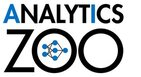
---

##### Copyright 2018 Analytics Zoo Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).


In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

**Install Analytics Zoo**

You can install the latest pre-release version with automl support using `pip install --pre --upgrade analytics-zoo[automl]`. 

In [ ]:
# Install latest pre-release version of Analytics Zoo 
# Installing Analytics Zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade analytics-zoo[automl]

## **Distributed automl for time series forecasting using Chronos AutoTS**

In this guide we will demonstrate how to use Chronos AutoTS for automated time seires forecasting in 4 simple steps.

## **Step 0: Prepare dataset**
We used NYC taxi passengers dataset in [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB) for demo, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot.

In [1]:
# download the dataset
!wget https://raw.githubusercontent.com/numenta/NAB/v1.0/data/realKnownCause/nyc_taxi.csv

--2021-07-14 16:18:48--  https://raw.githubusercontent.com/numenta/NAB/v1.0/data/realKnownCause/nyc_taxi.csv
Resolving child-prc.intel.com (child-prc.intel.com)... 10.109.19.68
Connecting to child-prc.intel.com (child-prc.intel.com)|10.109.19.68|:913... connected.
Proxy request sent, awaiting response... 200 OK
Length: 265771 (260K) [text/plain]
Saving to: ‘nyc_taxi.csv.7’

nyc_taxi.csv.7      100%[===================>] 259.54K   381KB/s    in 0.7s    

2021-07-14 16:18:50 (381 KB/s) - ‘nyc_taxi.csv.7’ saved [265771/265771]



In [2]:
# load the dataset. The downloaded dataframe contains two columns, "timestamp" and "value".
import pandas as pd
df = pd.read_csv("nyc_taxi.csv", parse_dates=["timestamp"])

In [3]:
# split the dataframe into train/validation/test set.
from zoo.chronos.preprocessing.utils import train_val_test_split
train_df, val_df, test_df = train_val_test_split(df, val_ratio=0.1, test_ratio=0.1)

### **Step 1: Init Orca Context** 

In [4]:
# import necesary libraries and modules
from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca import OrcaContext

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details.

**Note**: You should export HADOOP_CONF_DIR=/path/to/hadoop/conf/dir when you run on Hadoop YARN cluster.

In [5]:
# recommended to set it to True when running Analytics Zoo in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":  
    init_orca_context(cluster_mode="local", cores=4) # run in local mode
elif cluster_mode == "k8s":  
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=2) # run on K8s cluster
elif cluster_mode == "yarn":  
    init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2) # run on Hadoop YARN cluster

Initializing orca context
Current pyspark location is : /home/yuyin/spark-2.4.3-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /home/yuyin/analytics-zoo/zoo/target/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.11.0-SNAPSHOT-dist/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.11.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
2021-07-14 16:18:52 WARN  Utils:66 - Your hostname, intern04 resolves to a loopback address: 127.0.0.1; using 10.239.44.145 instead (on interface eno1)
2021-07-14 16:18:52 WARN  Utils:66 - Set SPARK_LOCAL_IP if you need to bind to another address
2021-07-14 16:18:52 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2021-07-14 16:18:53 WARN  Utils:66 - Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/home/yuyin/analytics-zoo/zoo/target/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.11.0-SNAPSHOT-dist/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.11.0-SNAPSHOT-jar-with-dependencies.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/yuyin/spark-2.4.3-bin-hadoop2.7/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


cls.getname: com.intel.analytics.bigdl.python.api.Sample
BigDLBasePickler registering: bigdl.util.common  Sample
cls.getname: com.intel.analytics.bigdl.python.api.EvaluatedResult
BigDLBasePickler registering: bigdl.util.common  EvaluatedResult
Successfully got a SparkContext
cls.getname: com.intel.analytics.bigdl.python.api.JTensor
BigDLBasePickler registering: bigdl.util.common  JTensor
cls.getname: com.intel.analytics.bigdl.python.api.JActivity
BigDLBasePickler registering: bigdl.util.common  JActivity



User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_MWAIT_HINTS=0
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_

### **Step 2: Create an AutoTSTrainer**


In [6]:
from zoo.chronos.autots.forecast import AutoTSTrainer

trainer = AutoTSTrainer(dt_col="timestamp",  # the column name specifying datetime
                        target_col="value",  # the column name to predict
                        horizon=1,           # number of steps to look forward
                        extra_features_col=None # a list of column names which are also included in input as features except dt_col and target_col.
                        )

### **Step 3: Fit with AutoTSTrainer**

Use a recipe to specify desired search space. `AutoTSTrainer` returns a result `TSPipeline` for easy deployment after fit.

In [7]:
from zoo.chronos.config.recipe import LSTMGridRandomRecipe
ts_pipeline = trainer.fit(train_df, val_df, 
                          recipe=LSTMGridRandomRecipe(
                              num_rand_samples=1,
                              epochs=1,
                              look_back=6, 
                              batch_size=[64]),
                          metric="mse")

2021-07-14 16:19:56,661	INFO tune.py:450 -- Total run time: 58.36 seconds (58.23 seconds for the tuning loop).


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### **Step 4: Further deployment with TSPipeline**

In [8]:
# predict with the best trial
pred_df = ts_pipeline.predict(test_df)

In [9]:
# evaluate the result pipeline
mse, smape = ts_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 2601798.080829584
Evaluate: the smape value is 8.702013491236286


In [10]:
# save the pipeline
my_ppl_file_path = ts_pipeline.save("/tmp/saved_pipeline/nyc_taxi.ppl")

IsADirectoryError: [Errno 21] Is a directory: '/tmp/saved_pipeline/nyc_taxi.ppl'

In [ ]:
# restore the pipeline for further deployment
from zoo.chronos.autots.forecast import TSPipeline
loaded_ppl = TSPipeline.load(my_ppl_file_path)

In [ ]:
# Stop orca context when your program finishes
stop_orca_context()